In [1]:
# Params
exp_name = None
output_dir = None
raw_dir = None

In [2]:
# # Debug
# exp_name = '0250kT-0uM-np-XY07-1'
# output_dir = '/lab/data/spheroid/20190822-co-culture/output/0250kT-0uM-np-XY07-1/v00'
# raw_dir = '/lab/data/spheroid/20190822-co-culture/raw/250kTcells-nopeptide/XY07'

In [3]:
for v in ['exp_name', 'output_dir', 'raw_dir']:
    assert globals()[v], '"{}" must be set'.format(v)

In [4]:
%matplotlib inline
%load_ext dotenv
%dotenv env.sh
%run source/utils.py
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path as osp
import tqdm
import collections
from centrosome import propagate
from scipy import ndimage as ndi
from skimage import util, morphology, transform, exposure, filters, feature, segmentation
from skimage import io as sk_io
from cytokit import io as ck_io
from cytokit import config as ck_config
from cytokit.cytometry.cytometer import CytometerBase
from cytokit.utils import ij_utils
from cytokit.function import data as ck_data
from cytokit.function import core as ck_core
from cytokit.ops import tile_generator, cytometry, tile_crop
from cytokit.image.ops import describe
from cytokit.exec import ilastik 
matplotlib.rc('image', cmap='gray')

In [5]:
df = pd.read_csv('experiments.csv')
df = df[df['name'] == exp_name]
assert len(df) == 1, 'Found {} rows for experiment {}'.format(len(df), exp_name)
df

,name,conf,dir,grid,n_ch,n_tiles,n_z,cond,rep,z_pitch
6,0250kT-0uM-np-XY07-1,experiment.yaml,250kTcells-nopeptide,XY07,4,33,8,0250kT-0uM-np,1,200


In [6]:
cyto_dir = osp.join(output_dir, 'cytometry')
cyto_dir

'/lab/data/spheroid/20190822-co-culture/output/0250kT-0uM-np-XY07-1/v00/cytometry'

In [7]:
ilastik_proj = os.environ['EXP_SPHEROID_ILASTIK_PRJ']
ilastik_proj

'/lab/data/spheroid/ilastik/mc38-co-culture/project/20190822-co-culture-maxz-bf-20x-25s.ilp'

In [8]:
config = ck_config.load(osp.join(output_dir, 'config'))
config.register_environment()
config

{'environment': {'path_formats': "get_default_path_formats('1_XY07_{tile:05d}_Z{z:03d}_CH{channel:d}.tif')"}, 'processor': {'cytometry': {'quantification_params': {'morphology_features': False, 'cell_graph': False, 'nucleus_intensity': True}, 'nuclei_channel_name': 'HOECHST'}, 'tile_generator': {'raw_file_type': 'keyence_mixed'}, 'deconvolution': {'scale_factor': 0.75, 'channels': ['HOECHST', 'ICYTE', 'SYTOX'], 'n_iter': 10}, 'args': {'run_cytometry': True, 'run_spectral_unmixing': False, 'gpus': [0, 1], 'run_best_focus': True, 'run_deconvolution': False}, 'best_focus': {'channel': 'HOECHST'}}, 'date': '2019-08-22 00:00:00', 'name': '0250kT-0uM-np-XY07-1', 'analysis': [{'aggregate_cytometry_statistics': {'mode': 'best_z_plane'}}, {'cellprofiler_quantification': {'export_db': True, 'export_csv': True}}], 'operator': [{'extract': {'name': 'best_z_segm', 'channels': ['proc_HOECHST', 'proc_ICYTE', 'proc_SYTOX', 'proc_BF', 'cyto_cell_boundary']}}, {'montage': {'name': 'best_z_segm', 'extrac

### Load All Images

In [9]:
tiles = get_tiles(config, raw_dir)
len(tiles)

100%|██████████| 33/33 [02:30<00:00,  4.62s/it]


33

In [10]:
img_mtg = ck_core.montage([t[0] for t in tiles], config)
img_mtg.shape

(1, 8, 4, 11088, 4032)

### Create max-z BF for spheroid segmentation

In [11]:
def get_maxz_projection(img_mtg):
    img = img_mtg[0, :, config.channel_names.index('BF')]
    img = util.img_as_float(img)
    img = util.invert(img)
    img = img.max(axis=0)
    # The target scale for BF segmentation is 25% of original 1440x1920 images
    img = transform.rescale(img, .25, anti_aliasing=True, multichannel=False, mode='constant', preserve_range=True)
    assert 0 <= img.min() <= img.max() <= 1
    img = exposure.rescale_intensity(img, in_range=(0, 1), out_range=np.uint8).astype(np.uint8)
    return img

In [12]:
img_bf_maxz = get_maxz_projection(img_mtg)
describe(img_bf_maxz)

{'bytes': 2794176,
 'max': 234,
 'mean': 98.33582315501958,
 'min': 61,
 'shape': (2772, 1008),
 'type': 'uint8'}

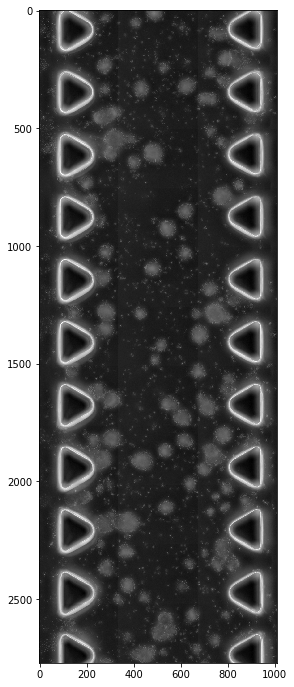

In [13]:
plt.imshow(img_bf_maxz)
plt.gcf().set_size_inches(6, 12)

### Spheroid Segmentation

In [14]:
def get_spheroid_probabilities(img, print_command=False, print_logs=False):
    export_source = 'Probabilities'
    input_path = osp.join(cyto_dir, 'ilastik', 'R001.BF.input.tif')
    output_path = osp.join(cyto_dir, 'ilastik', 'R001.BF.output.tif')
    os.makedirs(osp.dirname(input_path), exist_ok=True)
    sk_io.imsave(input_path, img)
    pres = ilastik.CLI.classify(ilastik_proj, input_path, output_path, export_source=export_source)
    if print_command:
        print('COMMAND: {}\n'.format(' '.join(pres.args)))
    if print_logs:
        print('STDOUT:\n{}'.format(pres.stdout.decode('utf-8')))
        print('STDERR:\n{}'.format(pres.stderr.decode('utf-8')))
    img = sk_io.imread(output_path)
    # Ilastik result is multi-channel image with channels in order of annotated class 
    # in project; assume first channel is class of interest and extract it here:
    assert img.ndim == 3, 'Expecting 2D image, got shape {}'.format(img.shape)
    img = img[..., 0]
    return img

In [15]:
img_proba = get_spheroid_probabilities(img_bf_maxz, print_command=False, print_logs=False)
describe(img_proba)

{'bytes': 11176704,
 'max': 1.0,
 'mean': 0.1505195,
 'min': 0.0,
 'shape': (2772, 1008),
 'type': 'float32'}

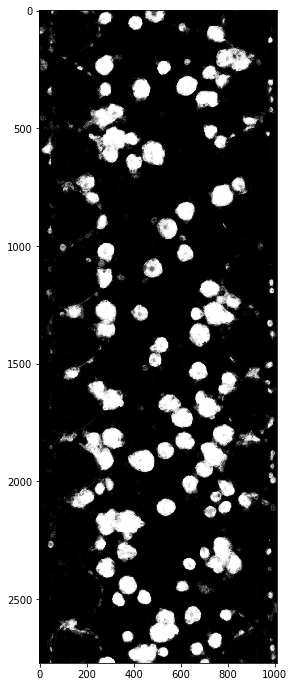

In [16]:
plt.imshow(img_proba)
plt.gcf().set_size_inches(6, 12)

In [17]:
def get_spheroid_mask(img, low=.5, high=.8, sigma=10):
    img = filters.gaussian(img, sigma=sigma)
    img = filters.apply_hysteresis_threshold(img, low, high)
    img = ndi.binary_fill_holes(img)
    return img

def get_spheroid_objects(img_segment, img_mask, min_peak_distance=16, regularization=.001):
    assert 0 <= img_segment.min() <= img_segment.max() <= 1
    img_dist = ndi.distance_transform_edt(img_mask)
    img_pk = feature.peak_local_max(img_dist, min_distance=min_peak_distance, indices=False)
    img_pk = morphology.label(img_pk)
    img_obj, _ = propagate.propagate(img_segment, img_pk, img_mask, regularization)
    return img_obj

In [18]:
img_mask = get_spheroid_mask(img_proba)
img_obj = get_spheroid_objects(util.img_as_float(img_bf_maxz), img_mask)

# Upsample to original size
img_obj = transform.resize(
    img_obj, img_mtg.shape[-2:], order=0, mode='constant', 
    anti_aliasing=False, preserve_range=True
).astype(img_obj.dtype)
assert img_obj.shape[-2:] == img_mtg.shape[-2:]
describe(img_obj)

{'bytes': 178827264,
 'max': 93,
 'mean': 6.294295706498088,
 'min': 0,
 'shape': (11088, 4032),
 'type': 'int32'}

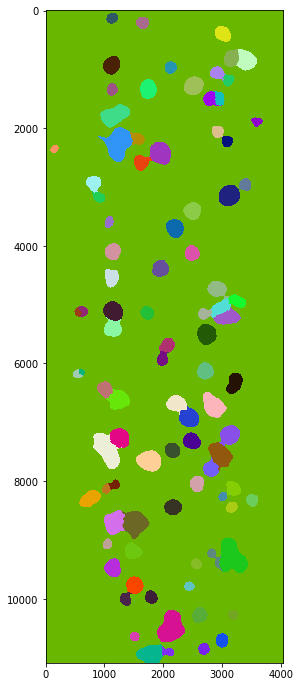

In [19]:
plt.imshow(img_obj, cmap=rand_cmap(1))
plt.gcf().set_size_inches(6, 12)

In [20]:
df_sph = CytometerBase.quantify(
    # Quantify averages over z channels 
    img_mtg.mean(axis=1)[np.newaxis], 
    # Duplicate spheroid body as center 
    np.stack([img_obj]*2)[np.newaxis],
    channel_names=config.channel_names,
    nucleus_intensity=False
)
df_sph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 20 columns):
id                 93 non-null int64
x                  93 non-null float64
y                  93 non-null float64
z                  93 non-null int64
cm:circularity     93 non-null float64
cm:diameter        93 non-null float64
cm:perimeter       93 non-null float64
cm:size            93 non-null int64
cm:solidity        93 non-null float64
nm:circularity     93 non-null float64
nm:diameter        93 non-null float64
nm:perimeter       93 non-null float64
nm:size            93 non-null int64
nm:solidity        93 non-null float64
cb:on_border       93 non-null int64
nb:on_border       93 non-null int64
ci:SYTOX:mean      93 non-null float64
ci:ICYTE:mean      93 non-null float64
ci:HOECHST:mean    93 non-null float64
ci:BF:mean         93 non-null float64
dtypes: float64(14), int64(6)
memory usage: 14.6 KB


In [21]:
# Export spheroid stats
path = osp.join(output_dir, 'cytometry', 'data.spheroid.csv')
df_sph.to_csv(path, index=False)
path

'/lab/data/spheroid/20190822-co-culture/output/0250kT-0uM-np-XY07-1/v00/cytometry/data.spheroid.csv'

### Cell Segmentation

In [21]:
cyto_op = cytometry.Cytometry2D(config, z_plane='all').initialize()

Using TensorFlow backend.


In [22]:
assert config.channel_names == cyto_op.quantification_params['channel_names']
cyto_op.quantification_params['channel_names']

['SYTOX', 'ICYTE', 'HOECHST', 'BF']

In [23]:
cyto_op.quantification_params['channel_names'] = cyto_op.quantification_params['channel_names'] + ['SPHEROID']
cyto_op.quantification_params['channel_names']

['SYTOX', 'ICYTE', 'HOECHST', 'BF', 'SPHEROID']

In [24]:
obj_map = {ti: tile for tile, ti in ck_core.unmontage(img_obj, config, strict=True)}

In [25]:
def repeat(img, nz):
    assert img.ndim == 2
    return np.repeat(img[np.newaxis, np.newaxis, np.newaxis], nz, axis=1)

In [27]:
repeat(list(obj_map.values())[0], config.n_z_planes).shape

(1, 9, 1, 504, 672)

In [28]:
def get_cell_segmentation():
    res = collections.OrderedDict()
    ct = 0
    for tile, tile_index in ck_core.unmontage(img_mtg, config, strict=True):
        # Get mask for spheroids (repeated along z dimension) and append to tile (as new channel on end)
        mask_tile = repeat(obj_map[tile_index] > 0, config.n_z_planes)
        tile = np.concatenate((tile, mask_tile.astype(tile.dtype)), axis=2)
        # Run segmentation and quantification
        tile, (tseg, tstat) = cyto_op.run(tile)
        res[tile_index] = tile, tseg, tstat
    return res
seg_res = get_cell_segmentation()

## Export

#### Tile Results

In [29]:
# Export per-tile results
for tile_index in seg_res:
    tile, tseg, tstat = seg_res[tile_index]
    paths = cyto_op.save(tile_index, output_dir, (tseg, tstat), compress=0)
    print('Saved cytometry data to paths ', paths)
# tags = ij_utils.get_slice_label_tags(['BF', 'MASK', 'BOUNDARY'] + CFLRO + CFLRO_QUANT)
# ck_io.save_tile(path, img_ext, config=config, infer_labels=False, extratags=tags)

Saved cytometry data to paths  ('cytometry/tile/R001_X001_Y001.tif', 'cytometry/statistics/R001_X001_Y001.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X002_Y001.tif', 'cytometry/statistics/R001_X002_Y001.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X003_Y001.tif', 'cytometry/statistics/R001_X003_Y001.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X003_Y002.tif', 'cytometry/statistics/R001_X003_Y002.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X002_Y002.tif', 'cytometry/statistics/R001_X002_Y002.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X001_Y002.tif', 'cytometry/statistics/R001_X001_Y002.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X001_Y003.tif', 'cytometry/statistics/R001_X001_Y003.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X002_Y003.tif', 'cytometry/statistics/R001_X002_Y003.csv')
Saved cytometry data to paths  ('cytometry/tile/R001_X003_Y003.tif', 'cytometry/statistics/R001_X003_Y00

In [ ]:
# Aggregate cell stats
ck_core.aggregate_cytometry_statistics(output_dir, config, mode='all')

#### Montage Results

In [30]:
img_mtg.shape, img_mtg.dtype

((1, 9, 4, 5544, 2016), dtype('uint16'))

In [33]:
img_obj_border = img_obj * segmentation.find_boundaries(img_obj, mode='inner').astype(img_obj.dtype)
img_obj.shape, img_obj.dtype, img_obj_border.shape, img_obj_border.dtype

((5544, 2016), dtype('int32'), (5544, 2016), dtype('int32'))

In [34]:
img_mtg_cell = ck_core.montage([v[1] for v in seg_res.values()], config)
img_mtg_cell.shape, img_mtg_cell.dtype

((1, 9, 4, 5544, 2016), dtype('uint16'))

In [35]:
# Build montage with original channels, spheroid objects, and cell + nucleus objects
# * For now, save only boundaries and not full masks
assert img_mtg.dtype == np.uint16
mtg_channels = config.channel_names + ['SPHEROID_BOUNDARY', 'CELL_BOUNDARY', 'NUCLEUS_BOUNDARY']
img_mtg_exp = np.concatenate((
    img_mtg,
    repeat(img_obj_border, config.n_z_planes).astype(np.uint16),
    # repeat(img_obj, config.n_z_planes).astype(np.uint16),
    img_mtg_cell[:, :, [2,3]].astype(np.uint16)
), axis=2)
assert len(mtg_channels) == img_mtg_exp.shape[2]
describe(img_mtg_exp)

{'bytes': 1408264704,
 'max': 65535,
 'mean': 8683.975744663696,
 'min': 0,
 'shape': (1, 9, 7, 5544, 2016),
 'type': 'uint16'}

In [36]:
mtg_channels

['SYTOX',
 'ICYTE',
 'HOECHST',
 'BF',
 'SPHEROID_BOUNDARY',
 'CELL_BOUNDARY',
 'NUCLEUS_BOUNDARY']

In [37]:
path = osp.join(output_dir, ck_io.get_montage_image_path(0, 'segm'))
os.makedirs(osp.dirname(path), exist_ok=True)
tags = ij_utils.get_channel_label_tags(mtg_channels, z=config.n_z_planes, t=1)
ck_io.save_tile(path, img_mtg_exp, config=config, infer_labels=False, extratags=tags)
path

'/lab/data/spheroid/20190719-co-culture/output/02.5mT-np-0uMsta-XY01/v00/montage/segm/R001.tif'